In [ ]:
!nvidia-smi
!cat /proc/cpuinfo

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 

In [ ]:
!pip install mne
!pip install pandas
!pip install numpy==1.14.0
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import os
import ntpath


import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 7.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 8.2 MB/s 
  ERROR: Failed building wheel for numpy
  Running setup.py clean for numpy
  ERROR: Failed cleaning build dir for numpy
Failed to build numpy
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
    Running setup.py install for numpy ... error
  Rolling back uninstall of numpy
  Moving to /usr/bin/f2py
   from /tmp/pip-uninstall-s6nzwz_5/f2py
  Moving to /usr/local/bin/f2py
   from /tmp/pip-uninstall-gubrb1k3/f2py
  Moving to /usr/local/bin/f2py3
   from /tmp/pip-uninstall-gubrb1k3/f2p

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating ~/mne_data


Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Using matplotlib as 2D backend.
Opening raw-browser...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


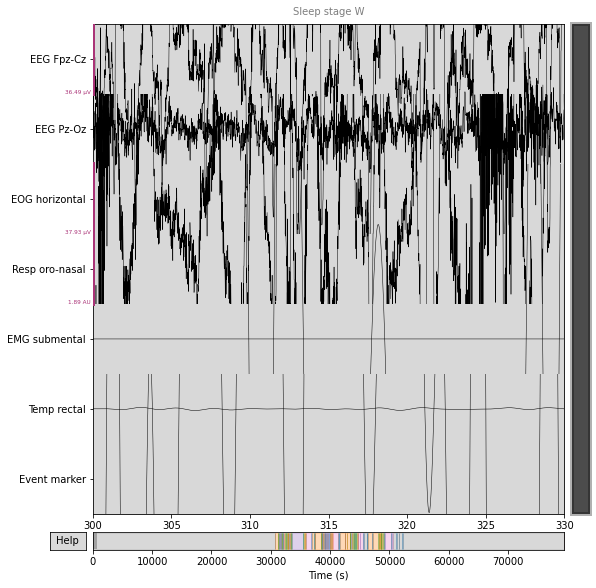

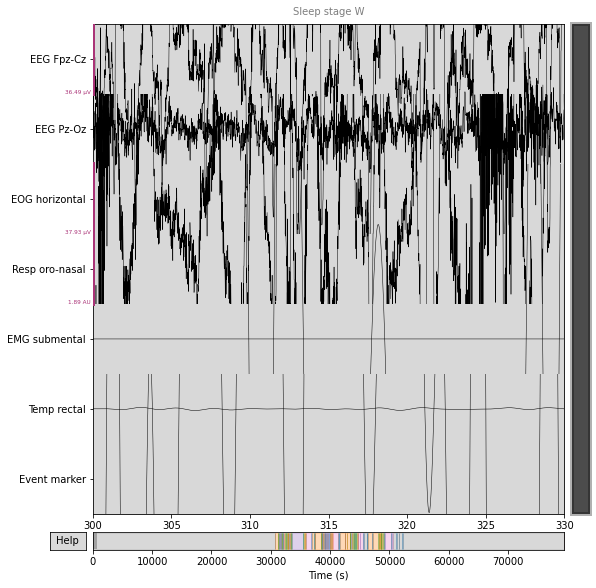

In [ ]:
[subject] = fetch_data(subjects=[0], recording=[1] )


#Mapping of the channels
mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}


# creating raw_train object with the *PSG.edf file of fetched data.
raw_train = mne.io.read_raw_edf(subject[0])

#The annot_train object has the annotations (labels) to be extracted from *Hypnogram.edf file of fetched data.
annot_train = mne.read_annotations(subject[1])
raw_train.set_annotations(annot_train, emit_warning=False)
raw_train.set_channel_types(mapping) #mapeo de canales

# plot some data
raw_train.plot(duration=30,scalings='auto', start=300 )


In [ ]:
print(raw_train.info)

#Sampling rate is an important variable
sampling_rate = raw_train.info['sfreq']

print('sampling_rate = {}'.format(sampling_rate))

<Info | 7 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG ...
 chs: 2 EEG, 1 EOG, 4 misc
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 1989-04-24 16:13:00 UTC
 nchan: 7
 projs: []
 sfreq: 100.0 Hz
>
sampling_rate = 100.0


In [ ]:
import re, datetime, operator
import numpy as np
from collections import namedtuple
from builtins import str

EVENT_CHANNEL = 'EDF Annotations'

class EDFEndOfData(BaseException): pass

def tal(tal_str):
  exp = '(?P<onset>[+\-]\d+(?:\.\d*)?)' + \
    '(?:\x15(?P<duration>\d+(?:\.\d*)?))?' + \
    '(\x14(?P<annotation>[^\x00]*))?' + \
    '(?:\x14\x00)'

  def annotation_to_list(annotation):
    return annotation.split('\x14') if annotation else [] #str(annotation, 'latin_1')

  def parse(dic):
    return (
      float(dic['onset']),
      float(dic['duration']) if dic['duration'] else 0.,
      annotation_to_list(dic['annotation']))

  return [parse(m.groupdict()) for m in re.finditer(exp, tal_str)]


def edf_header(f):
  h = {}
  assert f.tell() == 0  # check file position
  assert f.read(8) == '0       '

  # recording info)
  h['local_subject_id'] = f.read(80).strip()
  h['local_recording_id'] = f.read(80).strip()

  # parse timestamp
  (day, month, year) = [int(x) for x in re.findall('(\d+)', f.read(8))]
  (hour, minute, sec)= [int(x) for x in re.findall('(\d+)', f.read(8))]
  h['date_time'] = str(datetime.datetime(year + 2000, month, day,
    hour, minute, sec))

  # misc
  header_nbytes = int(f.read(8))
  subtype = f.read(44)[:5]
  h['EDF+'] = subtype in ['EDF+C', 'EDF+D']
  h['contiguous'] = subtype != 'EDF+D'
  h['n_records'] = int(f.read(8))
  h['record_length'] = float(f.read(8))  # in seconds
  nchannels = h['n_channels'] = int(f.read(4))

  # read channel info
  channels = range(h['n_channels'])
  h['label'] = [f.read(16).strip() for n in channels]
  h['transducer_type'] = [f.read(80).strip() for n in channels]
  h['units'] = [f.read(8).strip() for n in channels]
  h['physical_min'] = np.asarray([float(f.read(8)) for n in channels])
  h['physical_max'] = np.asarray([float(f.read(8)) for n in channels])
  h['digital_min'] = np.asarray([float(f.read(8)) for n in channels])
  h['digital_max'] = np.asarray([float(f.read(8)) for n in channels])
  h['prefiltering'] = [f.read(80).strip() for n in channels]
  h['n_samples_per_record'] = [int(f.read(8)) for n in channels]
  f.read(32 * nchannels)  # reserved

  assert f.tell() == header_nbytes
  return h


class BaseEDFReader:
  def __init__(self, file):
    self.file = file


  def read_header(self):
    self.header = h = edf_header(self.file)

    # calculate ranges for rescaling
    self.dig_min = h['digital_min']
    self.phys_min = h['physical_min']
    phys_range = h['physical_max'] - h['physical_min']
    dig_range = h['digital_max'] - h['digital_min']
    assert np.all(phys_range > 0)
    assert np.all(dig_range > 0)
    self.gain = phys_range / dig_range


  def read_raw_record(self):
    result = []
    for nsamp in self.header['n_samples_per_record']:
      samples = self.file.read(nsamp * 2)
      if len(samples) != nsamp * 2:
        raise EDFEndOfData
      result.append(samples)
    return result


  def convert_record(self, raw_record):
    h = self.header
    dig_min, phys_min, gain = self.dig_min, self.phys_min, self.gain
    time = float('nan')
    signals = []
    events = []
    for (i, samples) in enumerate(raw_record):
      if h['label'][i] == EVENT_CHANNEL:
        ann = tal(samples)
        time = ann[0][0]
        events.extend(ann[1:])
        # print(i, samples)
        # exit()
      else:
        # 2-byte little-endian integers
        dig = np.fromstring(samples, '<i2').astype(np.float32)
        phys = (dig - dig_min[i]) * gain[i] + phys_min[i]
        signals.append(phys)

    return time, signals, events


  def read_record(self):
    return self.convert_record(self.read_raw_record())


  def records(self):
    try:
      while True:
        yield self.read_record()
    except EDFEndOfData:
      pass


def load_edf(edffile):

  if isinstance(edffile, basestring):
    with open(edffile, 'rb') as f:
      return load_edf(f)  # convert filename to file

  reader = BaseEDFReader(edffile)
  reader.read_header()

  h = reader.header

  # get sample rate info
  nsamp = np.unique(
    [n for (l, n) in zip(h['label'], h['n_samples_per_record'])
    if l != EVENT_CHANNEL])
  assert nsamp.size == 1, 'Multiple sample rates not supported!'
  sample_rate = float(nsamp[0]) / h['record_length']

  rectime, X, annotations = zip(*reader.records())
  X = np.hstack(X)
  annotations = reduce(operator.add, annotations)
  chan_lab = [lab for lab in reader.header['label'] if lab != EVENT_CHANNEL]

  # create timestamps
  if reader.header['contiguous']:
    time = np.arange(X.shape[1]) / sample_rate
  else:
    reclen = reader.header['record_length']
    within_rec_time = np.linspace(0, reclen, nsamp, endpoint=False)
    time = np.hstack([t + within_rec_time for t in rectime])

  tup = namedtuple('EDF', 'X sample_rate chan_lab time annotations')
  return tup(X, sample_rate, chan_lab, time, annotations)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
input_data_path = '/content/drive/MyDrive/dataset/test'


# we iterate over all recordings and subjects
for r in [1,2]:
  for i in [i for i in np.arange(20)]:

    if (i == 13) & (r ==2):
      continue


    [s1_files] = fetch_data(subjects=[i], recording=[r])
    select_ch = 'EEG Fpz-Cz'
    print('Files loaded: {} and {}'.format(s1_files[0], s1_files[1]))

    #We generate the object with signal data for each recording
    raw = read_raw_edf(s1_files[0], preload=True, stim_channel=None)
    sampling_rate = raw.info['sfreq']
    raw_ch_df = raw.to_data_frame(scalings=100.0)[select_ch] #default="EEG Fpz-Cz",

    raw_ch_df = raw_ch_df.to_frame()
    raw_ch_df.set_index(np.arange(len(raw_ch_df)))


    # we obtain the recording's metadata, or header.
    f = open(s1_files[0], 'r', encoding = 'latin_1')
    reader_raw = BaseEDFReader(f)
    reader_raw.read_header()
    h_raw = reader_raw.header
    f.close()
    raw_start_dt = dt.strptime(h_raw['date_time'], "%Y-%m-%d %H:%M:%S")

    f = open(s1_files[1], 'r')
    reader_ann = BaseEDFReader(f)
    reader_ann.read_header()
    h_ann = reader_ann.header

    _, _, ann = zip(*reader_ann.records())
    f.close()
    ann_start_dt = dt.strptime(h_ann['date_time'], "%Y-%m-%d %H:%M:%S")

    assert raw_start_dt == ann_start_dt

    # Label values
    W = 0
    N1 = 1
    N2 = 2
    N3 = 3
    REM = 4
    UNKNOWN = 5

    stage_dict = { "W": W, "N1": N1, "N2": N2, "N3": N3, "REM": REM, "UNKNOWN": UNKNOWN }
    class_dict = { 0: "W", 1: "N1",  2: "N2", 3: "N3", 4: "REM", 5: "UNKNOWN" }
    ann2label = {  "Sleep stage W": 0, "Sleep stage 1": 1,"Sleep stage 2": 2, "Sleep stage 3": 3,
                "Sleep stage 4": 3,  "Sleep stage R": 4, "Sleep stage ?": 5, "Movement time": 5 }
    EPOCH_SEC_SIZE = 30


    # Vector with indices and labels
    remove_idx = []    # indicies of the data that will be removed
    labels = []        # indicies of the data that have labels
    label_idx = []
    for a in ann[0]:
      onset_sec, duration_sec, ann_char = a
      ann_str = "".join(ann_char)
      label = ann2label[ann_str]
      if label != UNKNOWN:
        if duration_sec % EPOCH_SEC_SIZE != 0:
          raise Exception("Something wrong")
        duration_epoch = int(duration_sec / EPOCH_SEC_SIZE)
        label_epoch = np.ones(duration_epoch, dtype=np.int) * label
        labels.append(label_epoch)
        idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
        label_idx.append(idx)

      else:
        idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
        remove_idx.append(idx)

    labels = np.hstack(labels)


    if len(remove_idx) > 0:
      remove_idx = np.hstack(remove_idx)
      select_idx = np.setdiff1d(np.arange(len(raw_ch_df)), remove_idx)
    else:
      select_idx = np.arange(len(raw_ch_df))

    # Only valid labels
    label_idx = np.hstack(label_idx)
    select_idx = np.intersect1d(select_idx, label_idx)


    # If necessary, extra indices are removed
    if len(label_idx) > len(select_idx):
        extra_idx = np.setdiff1d(label_idx, select_idx)
        # Vector tail is trimmed
        if np.all(extra_idx > select_idx[-1]):
            n_trims = len(select_idx) % int(EPOCH_SEC_SIZE * sampling_rate)
            n_label_trims = int(math.ceil(n_trims / (EPOCH_SEC_SIZE * sampling_rate)))
            select_idx = select_idx[:-n_trims]
            labels = labels[:-n_label_trims]


    raw_ch = raw_ch_df.values[select_idx]

    # Vector should be splittable into 30 second periods
    if len(raw_ch) % (EPOCH_SEC_SIZE * sampling_rate) != 0:
        raise Exception("Something wrong")
    n_epochs = len(raw_ch) / (EPOCH_SEC_SIZE * sampling_rate)

    x = np.asarray(np.split(raw_ch, n_epochs)).astype(np.float32)
    y = labels.astype(np.int32)

    assert len(x) == len(y)

    # We keep only section that correspond to sleep.
    w_edge_mins = 30
    nw_idx = np.where(y != stage_dict["W"])[0]
    start_idx = nw_idx[0] - (w_edge_mins * 2) #60  epochs before sleep onset
    end_idx = nw_idx[-1] + (w_edge_mins * 2) # 60 epochs after sleep is finished
    if start_idx < 0: start_idx = 0
    if end_idx >= len(y): end_idx = len(y) - 1
    select2_idx = np.arange(start_idx, end_idx+1)
    raw_datapoint = x.shape[0]
    x = x[select2_idx]
    selected_datapoints = x.shape[0]
    y = y[select2_idx]
    cal =  (raw_datapoint - selected_datapoints )*100/raw_datapoint

    #print("Register went down from {} to {} or {} percent".format(raw_datapoint, selected_datapoints, np.round(cal,2)))


    filename = ntpath.basename(s1_files[0]).replace("-PSG.edf", ".npz")
    save_dict = {
        "x": x,
        "y": y,
        "fs": sampling_rate,
        "ch_label": select_ch,
        "header_raw": h_raw,
        "header_annotation": h_ann,
    }



    np.savez(os.path.join('/content/gdrive/MyDrive/dataset/test, SC4001E0.npz'), **save_dict)

    print('File {} was processed and saved'.format(s1_files[0]))

    print("\n=======================================\n")

Using default location ~/mne_data for PHYSIONET_SLEEP...
Files loaded: /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4001EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

File /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4011EH-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8405999  =      0.000 ... 84059.990 secs...
File /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4021E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4021EH-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8411999  =      0.000 ... 84119.990 secs...
File /root/mne_data/physionet-sleep-data/SC4021E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4031E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4031EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8459999  =      0.000 ... 84599.990 secs...
File /root/mne_data/physionet-sleep-data/SC4031E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4041E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4041EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4041E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7709999  =      0.000 ... 77099.990 secs...
File /root/mne_data/physionet-sleep-data/SC4041E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4051E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4051EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4051E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8165999  =      0.000 ... 81659.990 secs...
File /root/mne_data/physionet-sleep-data/SC4051E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4061E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4061EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4061E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8309999  =      0.000 ... 83099.990 secs...
File /root/mne_data/physionet-sleep-data/SC4061E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4071E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4071EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4071E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8429999  =      0.000 ... 84299.990 secs...
File /root/mne_data/physionet-sleep-data/SC4071E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4081E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4081EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4081E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8387999  =      0.000 ... 83879.990 secs...
File /root/mne_data/physionet-sleep-data/SC4081E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4091E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4091EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4091E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8195999  =      0.000 ... 81959.990 secs...
File /root/mne_data/physionet-sleep-data/SC4091E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4101E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4101EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4101E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8159999  =      0.000 ... 81599.990 secs...
File /root/mne_data/physionet-sleep-data/SC4101E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4111E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4111EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4111E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7925999  =      0.000 ... 79259.990 secs...
File /root/mne_data/physionet-sleep-data/SC4111E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4121E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4121EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4121E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8357999  =      0.000 ... 83579.990 secs...
File /root/mne_data/physionet-sleep-data/SC4121E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4131E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4131EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4131E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8441999  =      0.000 ... 84419.990 secs...
File /root/mne_data/physionet-sleep-data/SC4131E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4141E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4141EU-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4141E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8267999  =      0.000 ... 82679.990 secs...
File /root/mne_data/physionet-sleep-data/SC4141E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4151E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4151EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4151E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7859999  =      0.000 ... 78599.990 secs...
File /root/mne_data/physionet-sleep-data/SC4151E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4161E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4161EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4161E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7877999  =      0.000 ... 78779.990 secs...
File /root/mne_data/physionet-sleep-data/SC4161E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4171E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4171EU-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4171E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8225999  =      0.000 ... 82259.990 secs...
File /root/mne_data/physionet-sleep-data/SC4171E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4181E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4181EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4181E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8267999  =      0.000 ... 82679.990 secs...
File /root/mne_data/physionet-sleep-data/SC4181E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4191E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4191EP-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4191E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8321999  =      0.000 ... 83219.990 secs...
File /root/mne_data/physionet-sleep-data/SC4191E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4002E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4002EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8489999  =      0.000 ... 84899.990 secs...
File /root/mne_data/physionet-sleep-data/SC4002E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4012E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4012EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8549999  =      0.000 ... 85499.990 secs...
File /root/mne_data/physionet-sleep-data/SC4012E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4022E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4022EJ-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4022E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8267999  =      0.000 ... 82679.990 secs...
File /root/mne_data/physionet-sleep-data/SC4022E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4032E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4032EP-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4032E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8195999  =      0.000 ... 81959.990 secs...
File /root/mne_data/physionet-sleep-data/SC4032E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4042E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4042EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4042E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8375999  =      0.000 ... 83759.990 secs...
File /root/mne_data/physionet-sleep-data/SC4042E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4052E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4052EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4052E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8417999  =      0.000 ... 84179.990 secs...
File /root/mne_data/physionet-sleep-data/SC4052E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4062E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4062EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4062E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8489999  =      0.000 ... 84899.990 secs...
File /root/mne_data/physionet-sleep-data/SC4062E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4072E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4072EH-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4072E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8309999  =      0.000 ... 83099.990 secs...
File /root/mne_data/physionet-sleep-data/SC4072E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4082E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4082EP-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4082E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7901999  =      0.000 ... 79019.990 secs...
File /root/mne_data/physionet-sleep-data/SC4082E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4092E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4092EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4092E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8573999  =      0.000 ... 85739.990 secs...
File /root/mne_data/physionet-sleep-data/SC4092E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4102E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4102EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4102E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8573999  =      0.000 ... 85739.990 secs...
File /root/mne_data/physionet-sleep-data/SC4102E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4112E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4112EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4112E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8339999  =      0.000 ... 83399.990 secs...
File /root/mne_data/physionet-sleep-data/SC4112E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4122E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4122EV-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4122E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7817999  =      0.000 ... 78179.990 secs...
File /root/mne_data/physionet-sleep-data/SC4122E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4142E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4142EU-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4142E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8321999  =      0.000 ... 83219.990 secs...
File /root/mne_data/physionet-sleep-data/SC4142E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4152E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4152EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4152E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8591999  =      0.000 ... 85919.990 secs...
File /root/mne_data/physionet-sleep-data/SC4152E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4162E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4162EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4162E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8255999  =      0.000 ... 82559.990 secs...
File /root/mne_data/physionet-sleep-data/SC4162E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4172E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4172EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4172E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8171999  =      0.000 ... 81719.990 secs...
File /root/mne_data/physionet-sleep-data/SC4172E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4182E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4182EC-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4182E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8525999  =      0.000 ... 85259.990 secs...
File /root/mne_data/physionet-sleep-data/SC4182E0-PSG.edf was processed and saved


Using default location ~/mne_data for PHYSIONET_SLEEP...


Files loaded: /root/mne_data/physionet-sleep-data/SC4192E0-PSG.edf and /root/mne_data/physionet-sleep-data/SC4192EV-Hypnogram.edf
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4192E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7829999  =      0.000 ... 78299.990 secs...
File /root/mne_data/physionet-sleep-data/SC4192E0-PSG.edf was processed and saved




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time
from datetime import datetime as dt
import pandas as pd
import os
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import Normalizer




#Functions

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

def _load_npz_file(npz_file):
    with np.load(npz_file) as f:
        data = f["x"]
        labels = f["y"]
        sampling_rate = f["fs"]
    return data, labels, sampling_rate

def _load_npz_list_files(npz_files):
    data = []
    labels = []
    fs = None
    for npz_f in npz_files:
        tmp_data, tmp_labels, sampling_rate = _load_npz_file(npz_f)
        if fs is None:
            fs = sampling_rate
        elif fs != sampling_rate:
            raise Exception("Found mismatch in sampling rate.")
        data.append(tmp_data)
        labels.append(tmp_labels)
    data = np.vstack(data)
    labels = np.hstack(labels)
    return data, labels

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.regularizers import l2
%tensorflow_version 2.x

print(tf.__version__)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.8.2
Num GPUs Available:  0


SystemError: ignored

In [ ]:
path = '/content/gdrive/MyDrive/dataset/test' #the path where the npz files were saved in the first notebook.

files = os.listdir(path)
filespath = []
for i in files:
  filespath.append(os.path.join(path,i))
X, Y = _load_npz_list_files(filespath)
#X, Y = numpy.load(filespath,allow_pickle=True)

X = X.reshape((X.shape[0], X.shape[1], 1))
print(X.shape, Y.shape)


In [ ]:
def cnn_builder(model_type):
  input_length = 15000 if model_type == 'CNN_CONCAT' else 3000

  inputs = keras.Input(shape=(input_length,1))

  #left leg - short filters

  x = layers.Conv1D( filters=64, kernel_size=50, strides=6 ,
                    name = 'conv1')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.MaxPool1D(pool_size=8, strides=8, name='max1')(x)

  x = layers.Dropout(rate=0.5  , name ='dropout1' )(x)

  x = layers.Conv1D(filters=128, kernel_size=8, strides=1,
                    name = 'conv2', padding = 'same' )(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv1D(filters=128, kernel_size=8, strides=1,
                    name = 'conv3', padding = 'same' )(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv1D(filters=128, kernel_size=8, strides=1,
                    name = 'conv4', padding = 'same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.MaxPool1D(pool_size=4, strides=4, name = 'max2')(x)
  x = layers.Flatten()(x)

  #right leg - longer filters
  x2 = layers.Conv1D( filters=64, kernel_size=400, strides=50 ,
                    name = 'conv1_2')(inputs)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU()(x2)

  x2 = layers.MaxPool1D(pool_size=4, strides=4, name='max1_2')(x2)

  x2 = layers.Dropout(rate=0.5  , name ='dropout1_2' )(x2)

  x2 = layers.Conv1D(filters=128, kernel_size=6, strides=1,
                    name = 'conv2_2', padding='same' )(x2)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU()(x2)

  x2 = layers.Conv1D(filters=128, kernel_size=6, strides=1,
                    name = 'conv3_2', padding='same' )(x2)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU()(x2)

  x2 = layers.Conv1D(filters=128, kernel_size=6, strides=1,
                    name = 'conv4_2', padding='same' )(x2)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU()(x2)

  x2 = layers.MaxPool1D(pool_size=2, strides=2, name = 'max2_2')(x2)

  x2 = layers.Flatten()(x2)
  #concatenate both legs
  concat = layers.Concatenate(name = 'concat')([x, x2])

  #final layer as softmax
  outputs = layers.Dense(5, activation=tf.nn.softmax, name = 'soft') (concat)

  model = keras.Model(inputs=inputs, outputs=outputs, name='sleep')

  return model

In [ ]:
n_split=5 # range between 10 - 20 folds

skf = StratifiedKFold(n_splits=n_split, random_state=47,shuffle=True)

cv_results = []
k = 0
for train_index,test_index in skf.split(X, Y):
  begin_time_loop = dt.now()


  X_train,X_test=X[train_index],X[test_index]
  y_train,y_test=Y[train_index],Y[test_index]

  k = k+1
  a = np.zeros((3000, 1))

  X_train = np.insert(X_train, 0, a, axis=0)
  X_train = np.insert(X_train, 0, a, axis=0)
  X_train = np.insert(X_train, -1, a, axis=0)
  X_train = np.insert(X_train, -1, a, axis=0)
  X_test = np.insert(X_test, 0, a, axis=0)
  X_test = np.insert(X_test, 0, a, axis=0)
  X_test = np.insert(X_test, -1, a, axis=0)
  X_test = np.insert(X_test, -1, a, axis=0)

  X_train2 = []
  for i in range(len(X_train)-4):
    j = i + 2
    clip = np.array([X_train[j-2], X_train[j-1], X_train[j], X_train[j+1], X_train[j+2]]).reshape((15000,1))
    X_train2.append(clip)

  X_test2 = []
  for i in range(len(X_test)-4):
    j = i + 2
    clip = np.array([X_test[j-2], X_test[j-1], X_test[j], X_test[j+1], X_test[j+2]]).reshape((15000,1))
    X_test2.append(clip)

  X_train_2=np.array(X_train2)
  X_test_2=np.array(X_test2)

  model = cnn_builder()

  #compile and define Adam optimizer
  model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

  history = model.fit(X_train_2, y_train,
                    batch_size=100,
                    epochs=6, verbose= 0)


  y_prob = model.predict(X_test_2)

  y_pred = y_prob.argmax(axis=-1)

  k_acc = accuracy_score(y_test,y_pred)
  print(k_acc)

  elapsed = dt.now() - begin_time_loop
  print('Fold {} took {}'.format(str(k), str(elapsed)))

  fold_result = {'fold': k, 'time': elapsed,'y_test': y_test, 'y_pred': y_pred, 'y_prob': y_prob,
               'history': history.history, 'accuracy': k_acc }


  del inputs, outputs, x1, x2, concat, model # delete model objects to guarantee each fold is trained from zero

  cv_results.append(fold_result)